In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian, convolve2d, correlate
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, img_as_ubyte, util, color
from skimage.metrics import peak_signal_noise_ratio

plt.style.use('dark_background')

# Declaration des filtres

In [2]:
# Scipy's version
def wiener(im, mysize=None, noise=None):
    """
    Perform a Wiener filter on an N-dimensional array.

    Apply a Wiener filter to the N-dimensional array `im`.

    Parameters
    ----------
    im : ndarray
        An N-dimensional array.
    mysize : int or array_like, optional
        A scalar or an N-length list giving the size of the Wiener filter
        window in each dimension.  Elements of mysize should be odd.
        If mysize is a scalar, then this scalar is used as the size
        in each dimension.
    noise : float, optional
        The noise-power to use. If None, then noise is estimated as the
        average of the local variance of the input.

    Returns
    -------
    out : ndarray
        Wiener filtered result with the same shape as `im`.

    Notes
    -----
    This implementation is similar to wiener2 in Matlab/Octave.
    For more details see [1]_
    """
    
    im = np.asarray(im)
    if mysize is None:
        mysize = [3] * im.ndim
    mysize = np.asarray(mysize)
    if mysize.shape == ():
        mysize = np.repeat(mysize.item(), im.ndim)

    # Estimate the local mean
    lMean = correlate(im, np.ones(mysize), 'same') / np.prod(mysize, axis=0)

    # Estimate the local variance
    lVar = (correlate(im ** 2, np.ones(mysize), 'same') /
            np.prod(mysize, axis=0) - lMean ** 2)

    # Estimate the noise power if needed.
    if noise is None:
        noise = np.mean(np.ravel(lVar), axis=0)

    res = (im - lMean)
    res *= (1 - noise / lVar)
    res += lMean
    out = np.where(lVar < noise, lMean, res)

    return out

In [3]:
# Le-Anh Tran's version
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    gauss = gauss / np.max(np.abs(gauss))
    noisy_img = img + gauss
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'same')
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def tran_wiener(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [4]:
# Andy Doran's code reimplemented by us in Python
def wien(image, No=0.01):
    xdim, ydim = image.shape

    # Create LSI degradation model, need it to be phaseless
    hi = 3.5**(-2)
    h = np.zeros((xdim, ydim))
    xl = 4
    xh = xdim - xl + 2
    h[0:xl, 0:xl] = hi
    h[xh:xdim, 0:xl] = hi
    h[0:xl, xh:ydim] = hi
    h[xh:xdim, xh:ydim] = hi

    # Calculate power spectral density of input image
    PICT = fft2(image)
    Suu = np.abs(PICT)**2

    # Calculate power spectral density of the noise (assuming Gaussian noise with variance No)
    Snn = No * np.ones((xdim, ydim))

    # Calculate Fourier Transform of LSI Filter
    H = fft2(h, (xdim, ydim))
    H2 = np.abs(H)**2

    # Calculate thresholded 1/H
    HINV = np.copy(H)
    index = np.where(np.abs(H) < 0.2)
    hzeros = len(index[0])  # Return number of elements below threshold
    HINV[index] = 0

    # Calculate Wiener Filter
    G = HINV * (H2 * Suu) / ((H2 * Suu) + Snn)

    # Restore Image
    DPICT = fft2(image)
    RPICT = DPICT * G
    rpict = np.abs(ifft2(RPICT))
    
    # Normalize image to the range [-1, 1]
    max_val = np.max(rpict)
    min_val = np.min(rpict)
    rpict = (rpict - min_val) / (max_val - min_val) * 2 - 1

    return rpict

In [5]:
# Based on the algorithm of Matlab
def our_wiener(image, neighborhood_size=(3, 3), noise=None):
    image_height, image_width = image.shape
    
    # Calculer le noyau de flou
    kernel = np.ones(neighborhood_size) / np.prod(neighborhood_size)

    # Flou de l'image
    blurred_image = convolve2d(image.astype(np.float64), kernel, mode='same')

    # Calculer la variance du bruit s'il n'est pas donné
    if noise is None:
        noise = np.mean(np.var(image))

    # Initialiser l'image filtrée
    filtered_image = np.zeros_like(image, dtype=np.float64)

    # Parcourir chaque pixel de l'image
    for i in range(image_height):
        for j in range(image_width):
            # Calculer les limites du voisinage local autour du pixel
            row_start = max(0, i - neighborhood_size[0] // 2)
            row_end = min(image_height, i + neighborhood_size[0] // 2 + 1)
            col_start = max(0, j - neighborhood_size[1] // 2)
            col_end = min(image_width, j + neighborhood_size[1] // 2 + 1)

            # Extraire le voisinage local flou
            local_blurred = blurred_image[row_start:row_end, col_start:col_end]

            # Estimer la moyenne locale et la variance locale
            local_mean = local_blurred[i - row_start, j - col_start]
            local_variance = np.mean(np.square(local_blurred - local_mean))

            # Appliquer le filtre de Wiener pixel par pixel
            filtered_pixel = local_mean + (local_variance - noise) / \
                             np.maximum(local_variance, noise) * \
                             (image[i, j] - local_mean)

            filtered_pixel = np.clip(filtered_pixel, 0, 1)
            # Assigner la valeur filtrée au pixel correspondant dans l'image filtrée
            filtered_image[i, j] = filtered_pixel

    return filtered_image.astype(image.dtype)

In [6]:
def display4(img1, img2, img3, img4, text_list):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    axes[0, 0].imshow(img1, cmap='gray')
    axes[0, 0].set_title(text_list[0])

    axes[0, 1].imshow(img2, cmap='gray')
    axes[0, 1].set_title(text_list[1])

    axes[1, 0].imshow(img3, cmap='gray')
    axes[1, 0].set_title(text_list[2])

    axes[1, 1].imshow(img4, cmap='gray')
    axes[1, 1].set_title(text_list[3])

    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Chargement et application des filtres

## Avec Saturne

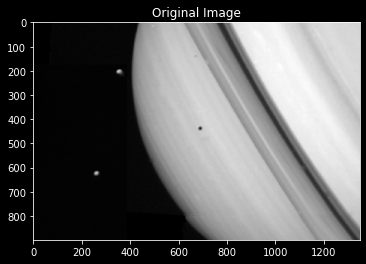

In [7]:
# Load greyscale image
original_image = io.imread('data/original_saturn.png')[:, :, :3]
original_image = color.rgb2gray(original_image)

# Gaussian Noise from Matlab with m = 0, sigma**2 = 0.025
sigma = np.sqrt(0.025)
noisy_image = io.imread('data/saturn.png')[:, :, :3]
noisy_image = color.rgb2gray(noisy_image)

plt.title('Original Image')
plt.imshow(original_image, cmap='gray')

In [8]:
# Application des filtres
scipy_image = wiener(noisy_image, mysize=3, noise=1.0)
tran_image = tran_wiener(noisy_image, gaussian_kernel(5), K=10)

filtered_image_3 = our_wiener(noisy_image, neighborhood_size=(3, 3))
filtered_image_5 = our_wiener(noisy_image, neighborhood_size=(5, 5))
filtered_image_7 = our_wiener(noisy_image, neighborhood_size=(7, 7))
our_image = filtered_image_3

/tmp/ipykernel_19762/3665322626.py:51: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/tmp/ipykernel_19762/3665322626.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


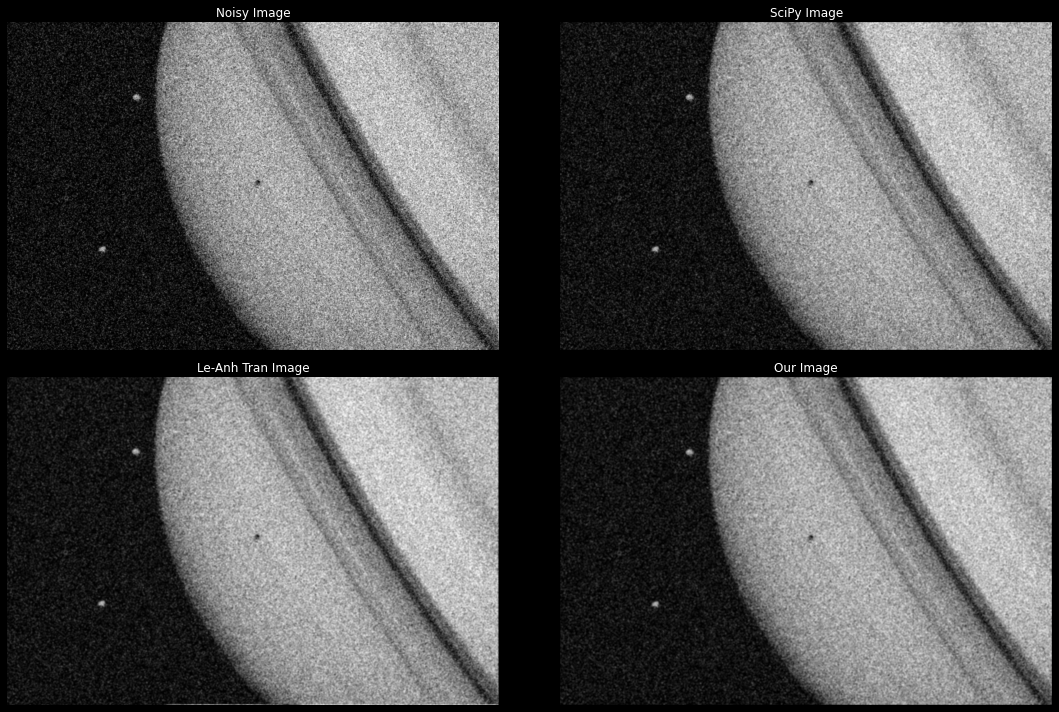

In [9]:
text_list = ['Noisy Image', 'SciPy Image', 'Le-Anh Tran Image', 'Our Image']
display4(noisy_image, scipy_image, tran_image, our_image, text_list)

### Analyse des metriques

In [10]:
original_image = img_as_ubyte(original_image)
scipy_image = img_as_ubyte(scipy_image)
tran_image = img_as_ubyte(tran_image)
our_image = img_as_ubyte(our_image)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image)
psnr_value_tran = peak_signal_noise_ratio(original_image, tran_image)
psnr_value_our = peak_signal_noise_ratio(original_image, our_image)

print("PSNR from us:", psnr_value_our)
print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from Le-Anh Tran:", psnr_value_tran)

PSNR from us: 21.240957827446568
PSNR from SciPy: 20.58977649375869
PSNR from Le-Anh Tran: 6.289033856591244


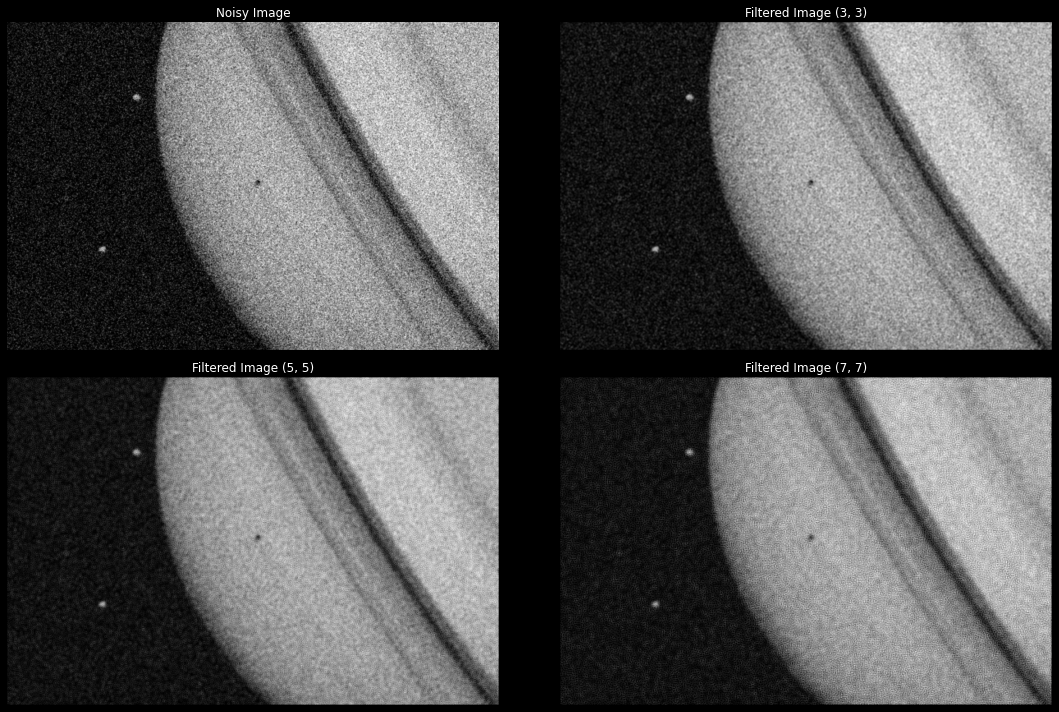

In [11]:
saturn_text_list_2 = ['Noisy Image', 'Filtered Image (3, 3)', 'Filtered Image (5, 5)', 'Filtered Image (7, 7)']
display4(noisy_image, filtered_image_3, filtered_image_5, filtered_image_7, saturn_text_list_2)

In [12]:
psnr_value_5 = peak_signal_noise_ratio(original_image, filtered_image_5)
psnr_value_7 = peak_signal_noise_ratio(original_image, filtered_image_7)

print("PSNR from (3, 3):", psnr_value_our)
print("PSNR from (5, 5):", psnr_value_5)
print("PSNR from (7, 7):", psnr_value_7)

PSNR from (3, 3): 21.240957827446568
PSNR from (5, 5): 5.574300609922503
PSNR from (7, 7): 5.574251141581653


/tmp/ipykernel_19762/2774127997.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value_5 = peak_signal_noise_ratio(original_image, filtered_image_5)
/tmp/ipykernel_19762/2774127997.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value_7 = peak_signal_noise_ratio(original_image, filtered_image_7)


## Avec Lenna

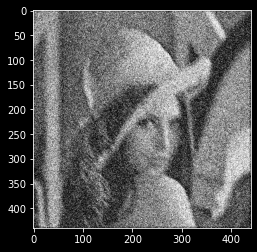

In [13]:
# Load greyscale image
original_image = io.imread('data/lena440.png')
original_image = color.rgb2gray(original_image)

# Blur it and add noise
sigma = 30
only_gaussian_noise_img = add_gaussian_noise(original_image, 1)
blurred_img = blur(original_image, kernel_size=9)
noisy_image = add_gaussian_noise(blurred_img, sigma=sigma)

# You can try with another type of noise
# noisy_image = util.random_noise(original_image, mode='gaussian', var=0.3, mean=-0.3)

plt.imshow(noisy_image, cmap='gray')

In [14]:
# Application des filtres
scipy_image = wiener(noisy_image, mysize=3, noise=1.0)
tran_image = tran_wiener(noisy_image, gaussian_kernel(5), K=10)
our_image = our_wiener(noisy_image, neighborhood_size=(3, 3))

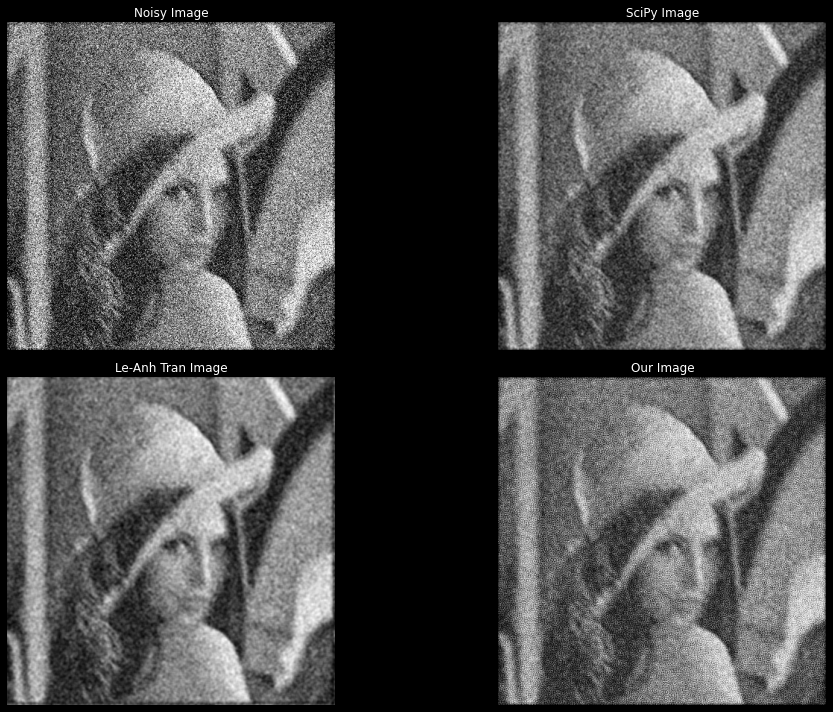

In [15]:
display4(noisy_image, scipy_image, tran_image, our_image, text_list)

### Analyse des metriques

In [16]:
original_image = img_as_ubyte(original_image)
scipy_image = img_as_ubyte(scipy_image)
tran_image = img_as_ubyte(tran_image)
our_image = img_as_ubyte(our_image)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image)
psnr_value_tran = peak_signal_noise_ratio(original_image, tran_image)
psnr_value_our = peak_signal_noise_ratio(original_image, our_image)

print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from us:", psnr_value_our)
print("PSNR from Le-Anh Tran:", psnr_value_tran)

PSNR from SciPy: 20.239043371505897
PSNR from us: 13.947109415375394
PSNR from Le-Anh Tran: 6.895664576018642


## Analyse des resultats

In [17]:
# only_gaussian_noise_img = add_gaussian_noise(original_image, 1)

In [18]:
scipy_image_blur = wiener(blurred_img, mysize=(7, 7), noise=sigma**2)
tran_image_blur = tran_wiener(blurred_img, gaussian_kernel(5), K=10)
our_image_blur = wien(blurred_img, sigma**2)

scipy_image_only_gaussian_noise= wiener(only_gaussian_noise_img, mysize=(7, 7), noise=sigma**2)
tran_image_only_gaussian_noise_img = tran_wiener(only_gaussian_noise_img, gaussian_kernel(5), K=10)
our_image_only_gaussian_noise_img = wien(only_gaussian_noise_img, sigma**2)

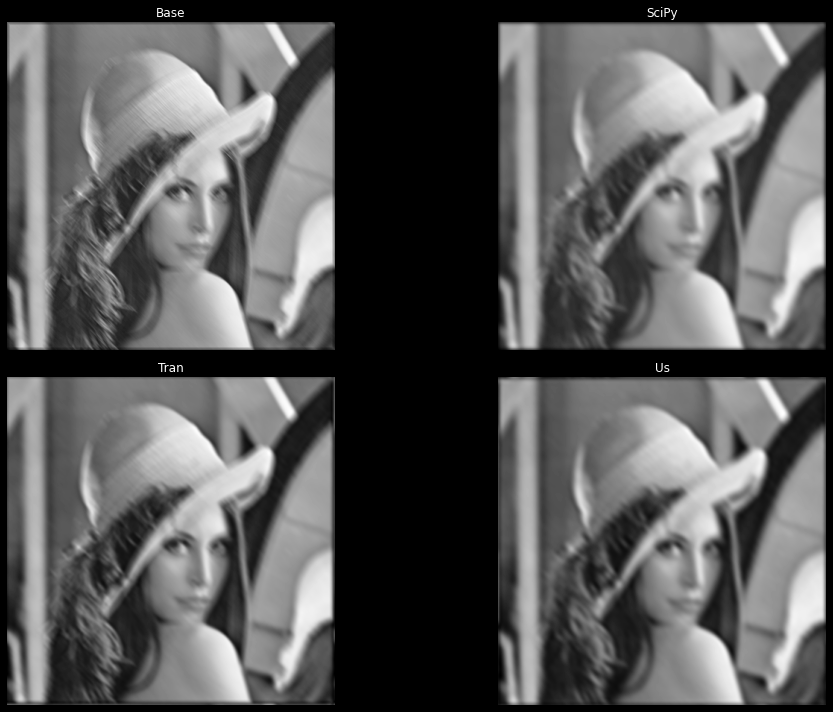

In [19]:
lena_text_list = ['Base', 'SciPy', 'Tran', 'Us']
display4(blurred_img, scipy_image_blur, tran_image_blur, our_image_blur, lena_text_list)

In [20]:
scipy_image_blur = img_as_ubyte(scipy_image_blur)
tran_image_blur = img_as_ubyte(tran_image_blur)
our_image_blur = img_as_ubyte(our_image_blur)
blur_img = img_as_ubyte(blurred_img)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image_blur)
psnr_value_tran = peak_signal_noise_ratio(original_image, tran_image_blur)
psnr_value_our = peak_signal_noise_ratio(original_image, our_image_blur)
psnr_blur_img = peak_signal_noise_ratio(original_image, blur_img)

print("PSNR from blur:", psnr_blur_img)
print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from us:", psnr_value_our)
print("PSNR from Tran:", psnr_value_tran)

PSNR from blur: 23.994976575448725
PSNR from SciPy: 22.910979582477
PSNR from us: 9.27371978813977
PSNR from Tran: 6.899532430689201


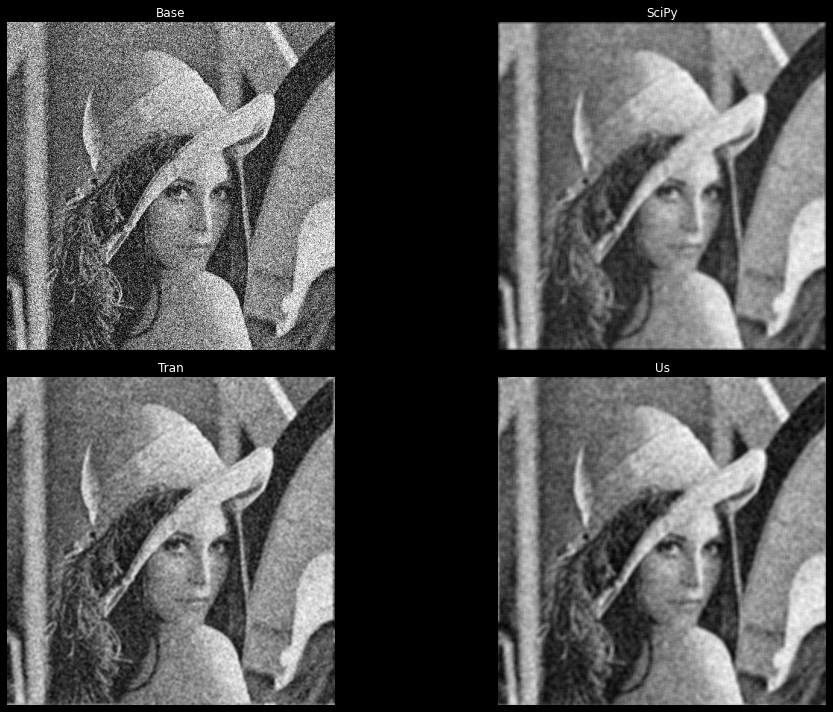

In [21]:
display4(only_gaussian_noise_img, scipy_image_only_gaussian_noise, tran_image_only_gaussian_noise_img, our_image_only_gaussian_noise_img, lena_text_list)

In [24]:
original_image = img_as_ubyte(original_image)
scipy_image_only_gaussian_noise = img_as_ubyte(scipy_image_only_gaussian_noise)
tran_image_only_gaussian_noise = img_as_ubyte(tran_image_only_gaussian_noise_img)
our_image_only_gaussian_noise = img_as_ubyte(our_image_only_gaussian_noise_img)
noise_img_only_gaussian_noise = img_as_ubyte(only_gaussian_noise_img)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image_only_gaussian_noise)
psnr_value_tran = peak_signal_noise_ratio(original_image, tran_image_only_gaussian_noise)
psnr_value_our = peak_signal_noise_ratio(original_image, our_image_only_gaussian_noise)

print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from us:", psnr_value_our)
print("PSNR from Tran:", psnr_value_tran)
print("PSNR noise:", peak_signal_noise_ratio(original_image, only_gaussian_noise_img))

PSNR from SciPy: 24.022413748086613
PSNR from us: 9.205822845683382
PSNR from Tran: 6.910674951558145
PSNR noise: 6.135767469018118


/tmp/ipykernel_19762/3032210867.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("PSNR noise:", peak_signal_noise_ratio(original_image, only_gaussian_noise_img))


# Autre version qu'on a considere

In [23]:
# Eric Tramel's version 
def eric_tramel_wiener(g, nhood=(3, 3), noise=None):
    classin = g.dtype
    classChanged = False
    if g.dtype != np.float64:
        classChanged = True
        g = g.astype(np.float64)

    # Estimate the local mean of f.
    localMean = np.mean(g, axis=(0, 1))

    # Estimate of the local variance of f.
    localVar = np.var(g, axis=(0, 1))

    # Estimate the noise power if necessary.
    if noise is None:
        noise = np.mean(localVar)

    # Compute result
    f = g - localMean
    g = localVar - noise
    g = np.maximum(g, 0)
    localVar = np.maximum(localVar, noise)
    f = f / localVar
    f = f * g
    f = f + localMean

    if classChanged:
        f = f.astype(classin)

    return f